# 3D Erythrocyte Reconstruction from Interferograms

In [15]:
!unzip single_erythrocytes_5.zip

Archive:  single_erythrocytes_5.zip
replace single_erythrocytes_5/5_1.bmp? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [19]:
img = cv2.imread("single_erythrocytes_5/5_1.bmp", cv2.IMREAD_GRAYSCALE)

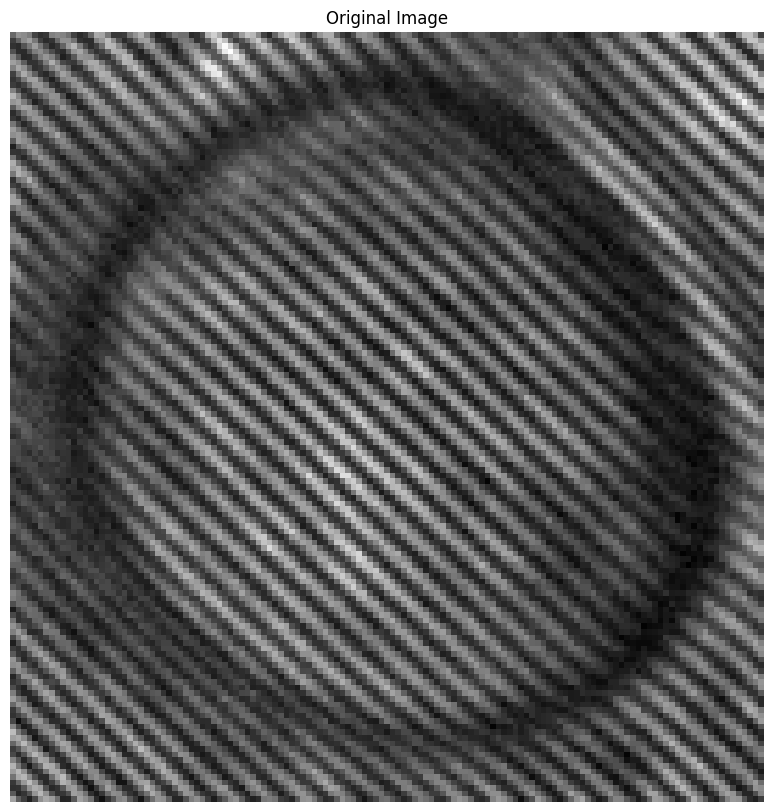

In [20]:
img = img.astype(np.float32)
rows, cols = img.shape
plt.figure(figsize=(10, 10))
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis("off")
plt.show()

## 2D Fourier transform

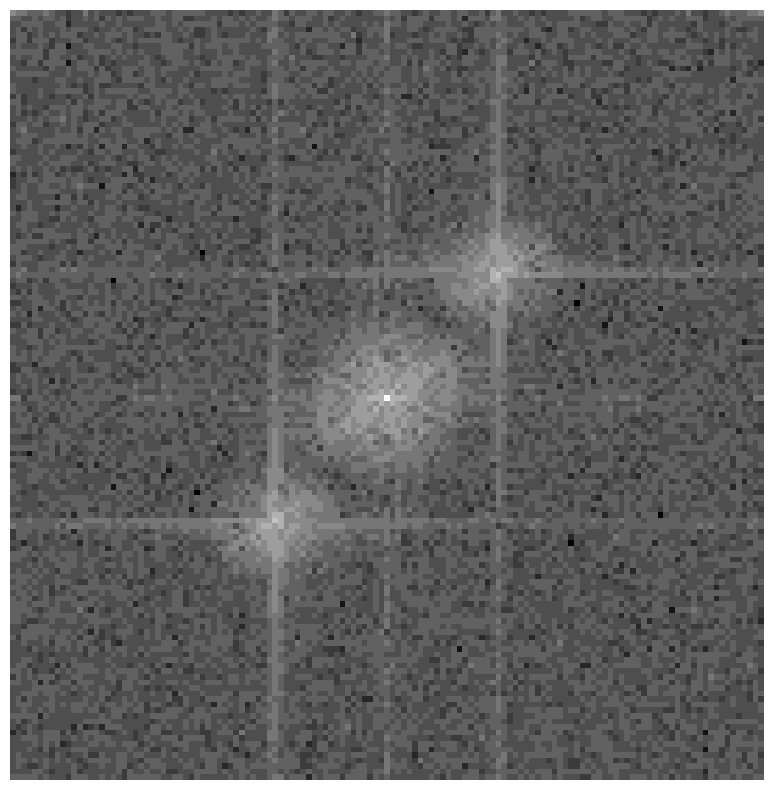

In [23]:
fft = np.fft.fftshift(np.fft.fft2(img))
spectrum = np.log(1 + np.abs(fft))
plt.figure(figsize=(10, 10))
plt.imshow(spectrum.astype(np.uint8), cmap='gray')
plt.axis('off')
plt.show()

## Finding the first order

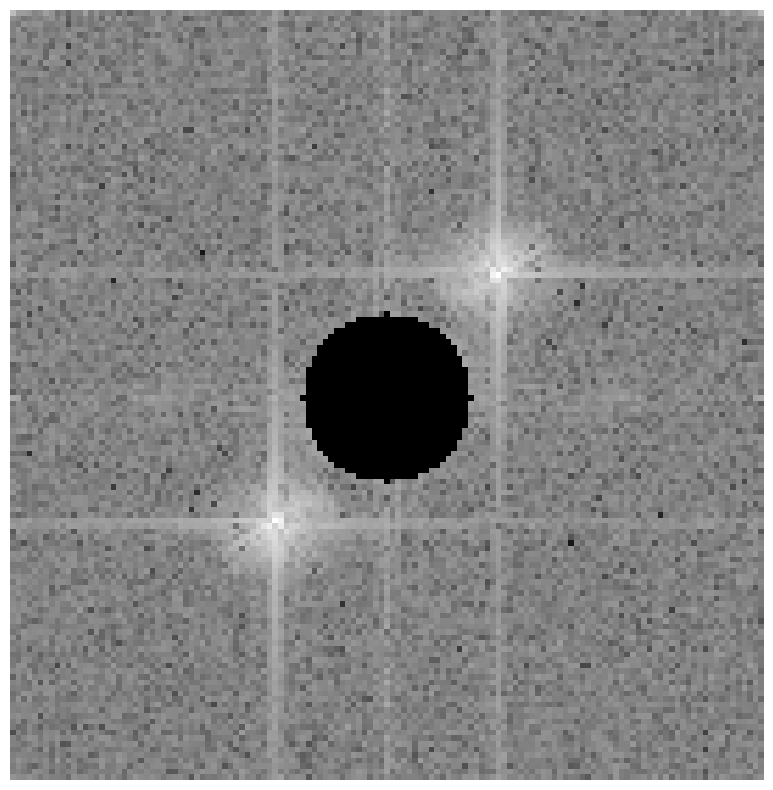

In [24]:
h, w = img.shape
cy, cx = h//2, w//2

# masking the center before searching for the first order
mask_radius = 15
Y, X = np.ogrid[:h, :w]
center_mask = (X-cx)**2 + (Y-cy)**2 <= mask_radius**2
spectrum_masked = spectrum.copy()
spectrum_masked[center_mask] = 0

max_y, max_x = np.unravel_index(np.argmax(spectrum_masked), spectrum_masked.shape)
f_x_est, f_y_est = max_x-cx, max_y-cy
f_x, f_y = f_x_est, f_y_est

plt.figure(figsize=(10, 10))
plt.imshow(spectrum_masked, cmap='gray')
plt.axis('off')
plt.show()

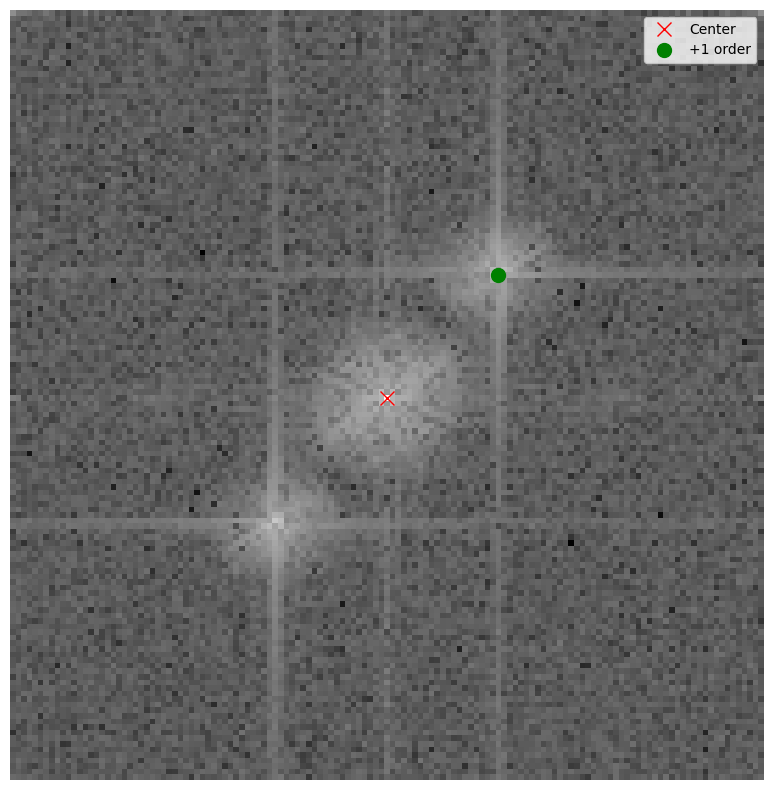

In [25]:
plt.figure(figsize=(10, 10))
plt.imshow(spectrum, cmap='gray')
plt.plot(cx, cy, 'rx', markersize=10, label='Center')
plt.plot(cx+f_x, cy+f_y, 'go', markersize=10, label='+1 order')
plt.legend()
plt.axis('off')
plt.show()

## Isolating the +1 order

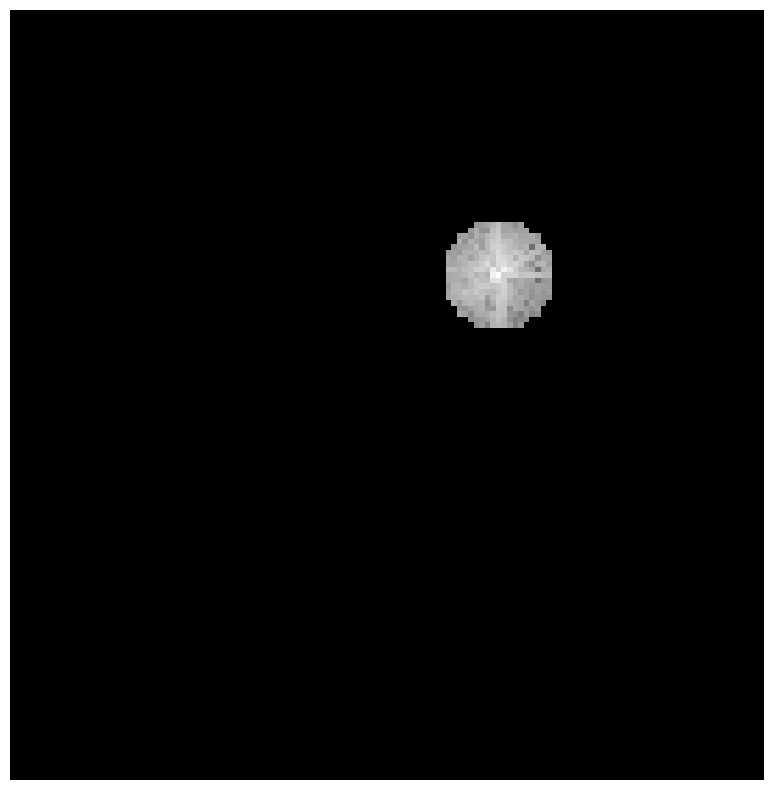

In [26]:
filter_radius = 10
filter_mask = np.zeros((h, w), dtype=bool)
pos_y, pos_x = cy + int(f_y), cx + int(f_x)

Y, X = np.ogrid[:h, :w]
dist_sq = (Y - pos_y)**2 + (X - pos_x)**2
filter_mask = dist_sq < filter_radius**2


fft_filtered = np.zeros_like(fft, dtype=complex)
fft_filtered[filter_mask] = fft[filter_mask]
filtered_spectrum = np.log(1 + np.abs(fft_filtered))

plt.figure(figsize=(10, 10))
plt.imshow(filtered_spectrum, cmap='gray')
plt.axis('off')
plt.show()

In [27]:
def visualize_image_from_fft(spectrum):
  inverse = np.fft.ifft2(np.fft.ifftshift(spectrum))
  img = np.log(1 + np.abs(inverse))
  plt.imshow(img , cmap='gray')
  plt.axis('off')
  plt.show()


## Moving the first order to the image center

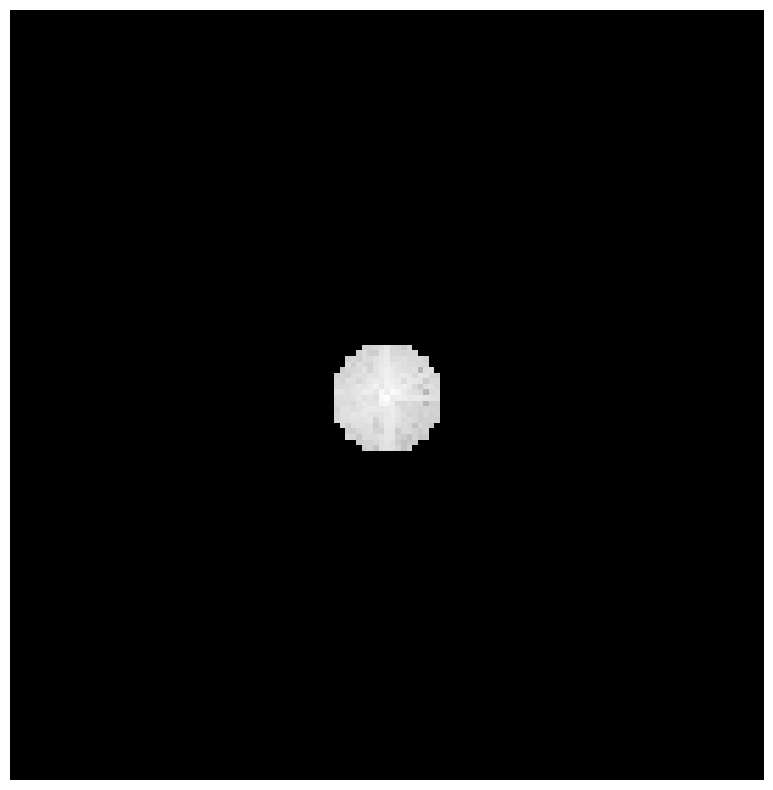

In [29]:
fft_centered = np.roll(fft_filtered, -int(f_y), axis=0)
fft_centered = np.roll(fft_centered, -int(f_x), axis=1)
centered_spectrum = np.log(1 + np.abs(fft_centered))

plt.figure(figsize=(10, 10))
plt.imshow(np.log(1 + np.abs(centered_spectrum)), cmap='gray')
plt.axis('off')
plt.show()

## Reverse Fourier Transform

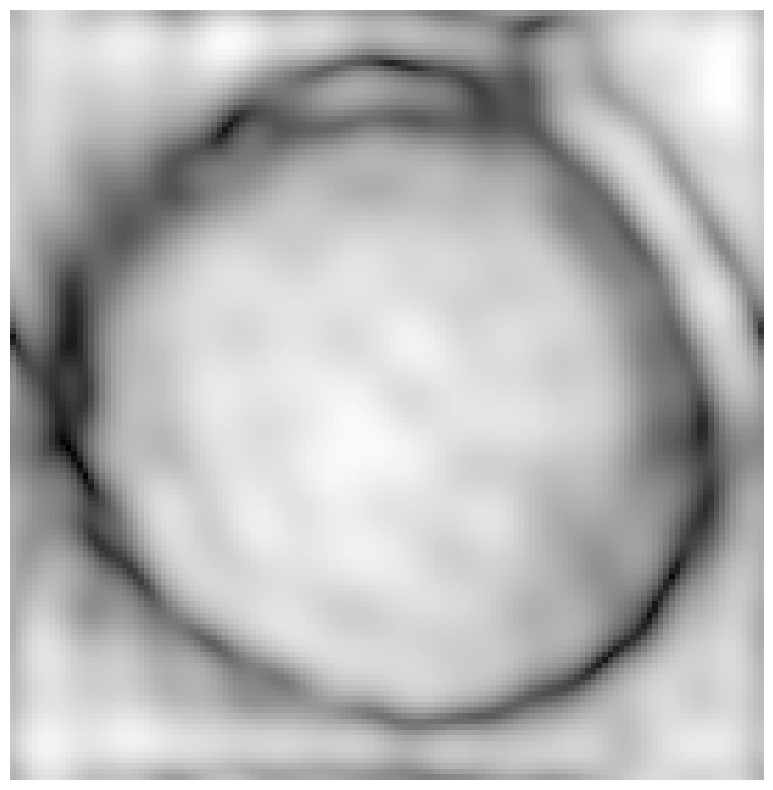

In [31]:
complex_field = np.fft.ifft2(np.fft.ifftshift(fft_centered))

plt.figure(figsize=(10, 10))
plt.imshow(np.log(1 + np.abs(complex_field)), cmap='gray')
plt.axis('off')
plt.show()

## Calculating the phase as a complex part of the signal

In [32]:
phase_wrapped = np.angle(complex_field)

phase_unwrapped = np.unwrap(np.unwrap(phase_wrapped, axis=1), axis=0)

## Creating a 3D plot

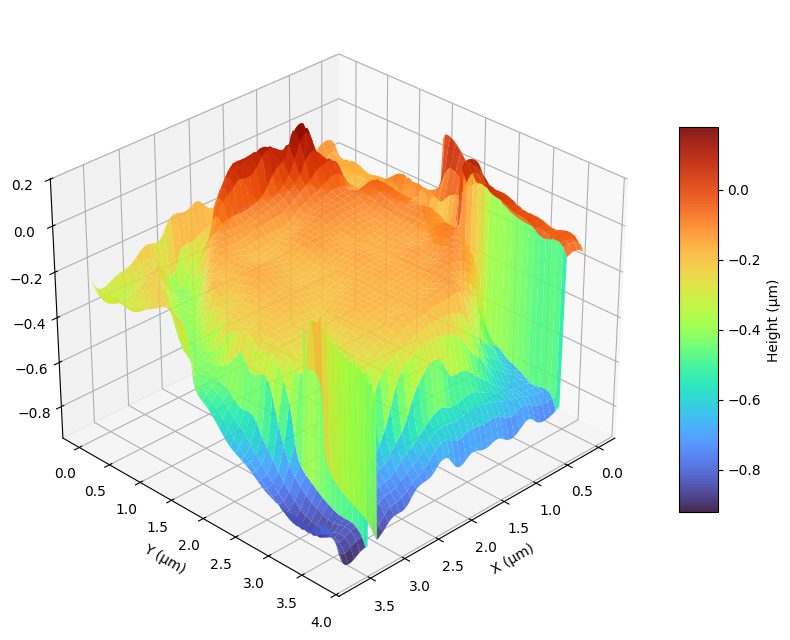

In [48]:
pixel_size = 2.2
wavelength = 0.65
zoom = 80

step = 1
x = np.arange(0, w, step)
y = np.arange(0, h, step)
X_3d, Y_3d = np.meshgrid(x, y)
Z_3d = phase_unwrapped[::step, ::step]

X_microns = X_3d * pixel_size / zoom
Y_microns = Y_3d * pixel_size / zoom
Z_microns = Z_3d * wavelength / (2 * np.pi)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

z_min = Z_microns.min()
z_max = Z_microns.max()

surf = ax.plot_surface(X_microns, Y_microns, Z_microns,
                      cmap='turbo',
                      alpha=0.9,
                      linewidth=0.1,
                      antialiased=True,
                      vmin=z_min,
                      vmax=z_max)

fig.colorbar(surf, shrink=0.5, aspect=10, label='Height (μm)')
ax.view_init(elev=30, azim=45)

ax.set_xlabel('X (μm)')
ax.set_ylabel('Y (μm)')
fig.show()

## Full function for creating a 3D plot of an erythrocyte

In [34]:
def plot_3d_erythrocyte(img, pixel_size = 2.2, wavelength = 0.65, zoom = 80, mask_radius = 15, filter_radius = 10):
    rows, cols = img.shape
    fft = np.fft.fftshift(np.fft.fft2(img))
    spectrum = np.log(1 + np.abs(fft))
    h, w = img.shape
    cy, cx = h//2, w//2

    Y, X = np.ogrid[:h, :w]
    center_mask = (X-cx)**2 + (Y-cy)**2 <= mask_radius**2
    spectrum_masked = spectrum.copy()
    spectrum_masked[center_mask] = 0

    max_y, max_x = np.unravel_index(np.argmax(spectrum_masked), spectrum_masked.shape)
    f_x_est, f_y_est = max_x-cx, max_y-cy
    f_x, f_y = f_x_est, f_y_est

    filter_mask = np.zeros((h, w), dtype=bool)
    pos_y, pos_x = cy + int(f_y), cx + int(f_x)

    Y, X = np.ogrid[:h, :w]
    dist_sq = (Y - pos_y)**2 + (X - pos_x)**2
    filter_mask = dist_sq < filter_radius**2


    fft_filtered = np.zeros_like(fft, dtype=complex)
    fft_filtered[filter_mask] = fft[filter_mask]
    filtered_spectrum = np.log(1 + np.abs(fft_filtered))

    fft_filtered = np.zeros_like(fft, dtype=complex)
    fft_filtered[filter_mask] = fft[filter_mask]

    fft_centered = np.roll(fft_filtered, -int(f_y), axis=0)
    fft_centered = np.roll(fft_centered, -int(f_x), axis=1)

    complex_field = np.fft.ifft2(np.fft.ifftshift(fft_centered))

    phase_wrapped = np.angle(complex_field)

    phase_unwrapped = np.unwrap(np.unwrap(phase_wrapped, axis=1), axis=0)

    step = 1
    x = np.arange(0, w, step)
    y = np.arange(0, h, step)
    X_3d, Y_3d = np.meshgrid(x, y)
    Z_3d = phase_unwrapped[::step, ::step]

    X_microns = X_3d * pixel_size / zoom
    Y_microns = Y_3d * pixel_size / zoom
    Z_microns = Z_3d * wavelength / (2 * np.pi)

    ax = plt.gca()
    fig = plt.gcf()

    z_min = Z_microns.min()
    z_max = Z_microns.max()

    surf = ax.plot_surface(X_microns, Y_microns, Z_microns,
                          cmap='turbo',
                          alpha=0.9,
                          linewidth=0.1,
                          antialiased=True,
                          vmin=z_min,
                          vmax=z_max)


    fig.colorbar(surf, shrink=0.5, aspect=10, label='Height (μm)')
    ax.view_init(elev=30, azim=45)

    ax.set_xlabel('X (μm)')
    ax.set_ylabel('Y (μm)')

In [35]:
def plot_single_3d_erythrocyte(img, pixel_size = 2.2, wavelength = 0.65, zoom = 80, mask_radius = 15, filter_radius = 10):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    plot_3d_erythrocyte(img, pixel_size = pixel_size, wavelength = wavelength, zoom = zoom, mask_radius = mask_radius, filter_radius = filter_radius)
    plt.show()

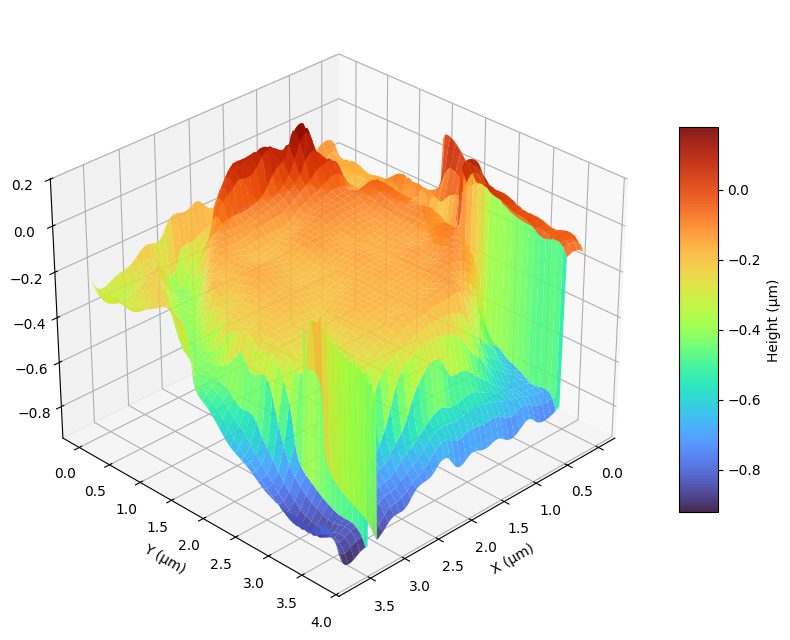

In [36]:
plot_single_3d_erythrocyte(img)

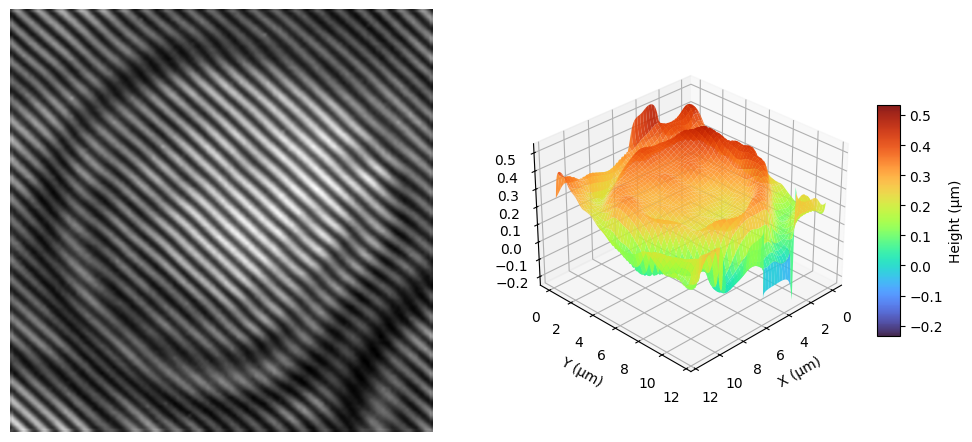

In [39]:
img1 = cv2.imread("/content/presentation_img.png", cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img1, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2, projection='3d')
plot_3d_erythrocyte(img1)

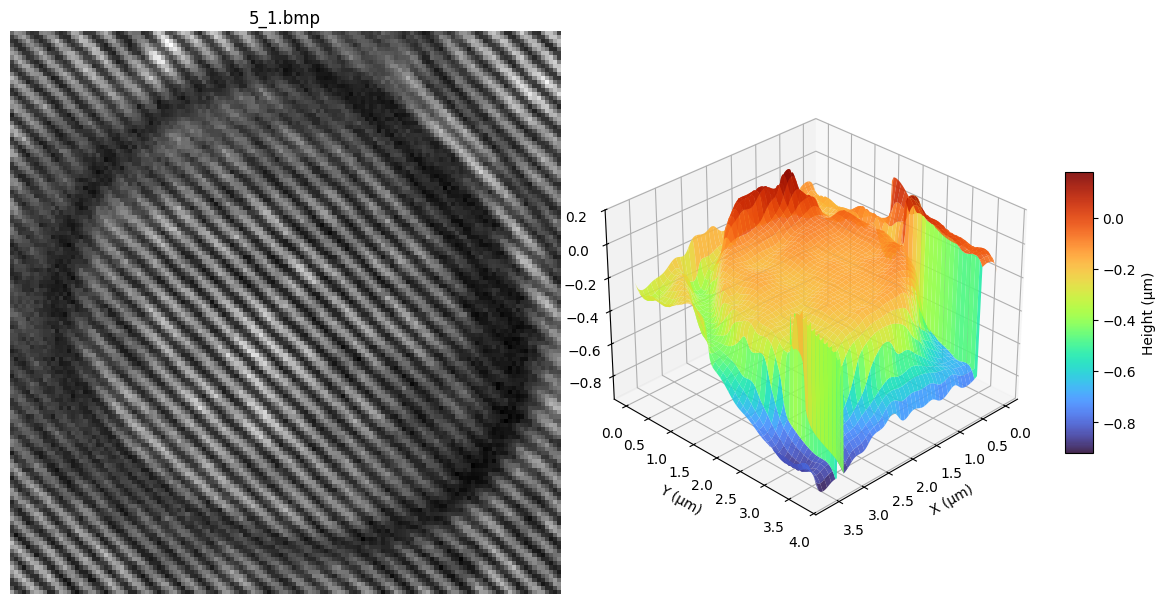

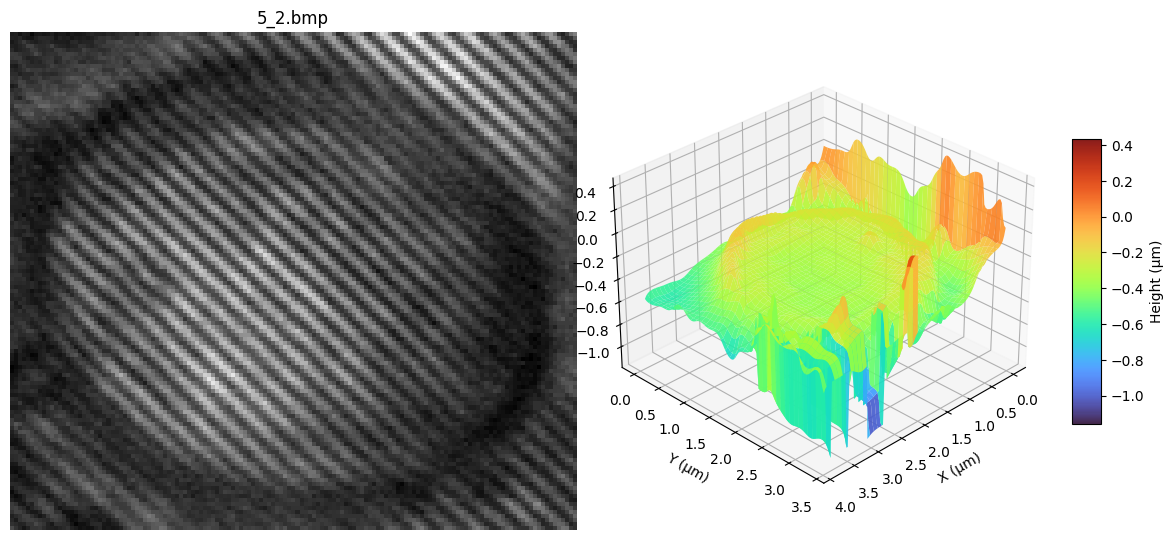

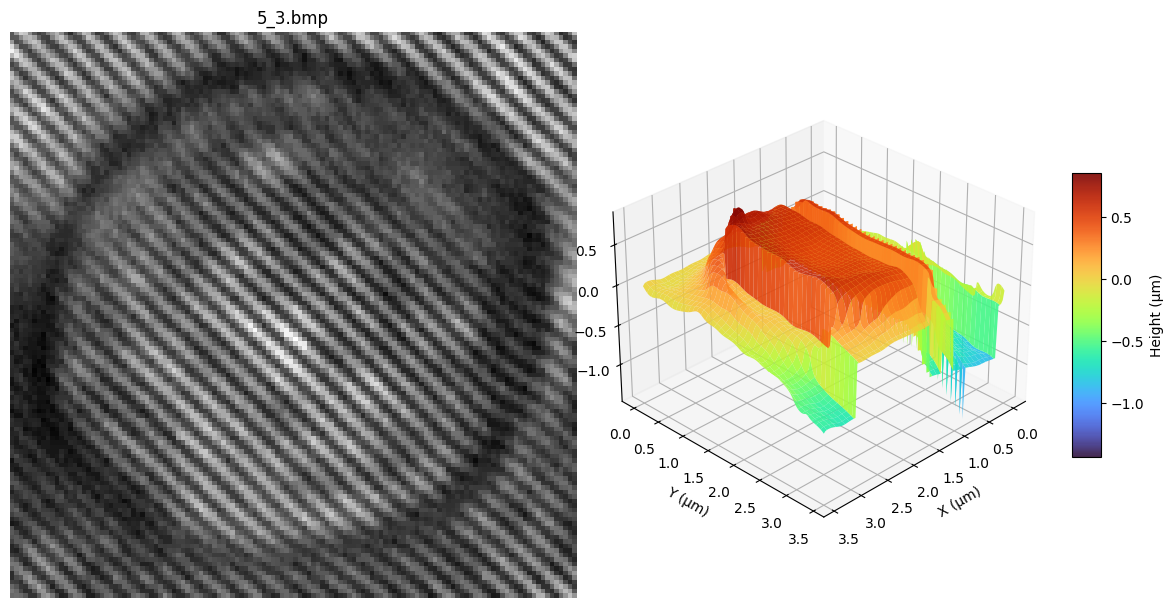

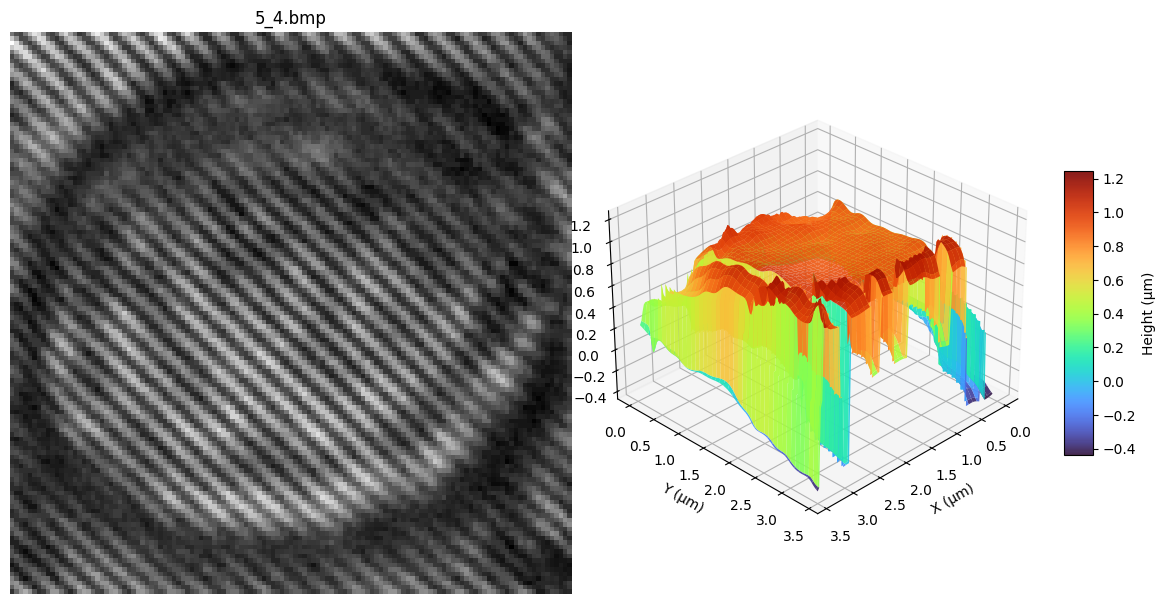

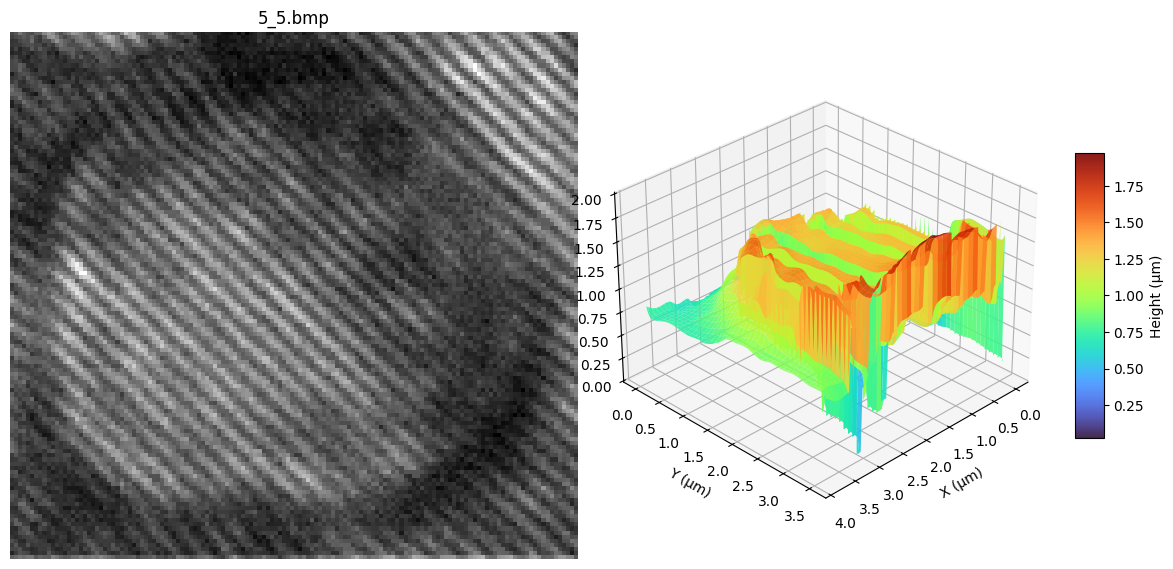

In [40]:
import os
import cv2
import matplotlib.pyplot as plt

files = os.listdir("/content/single_erythrocytes_5")
files.sort()

for index, filename in enumerate(files):
    image = cv2.imread("/content/single_erythrocytes_5/" + filename, cv2.IMREAD_GRAYSCALE)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title(filename)
    plt.axis('off')

    plt.subplot(1, 2, 2, projection='3d')
    plot_3d_erythrocyte(image)

    plt.tight_layout()
    plt.show()

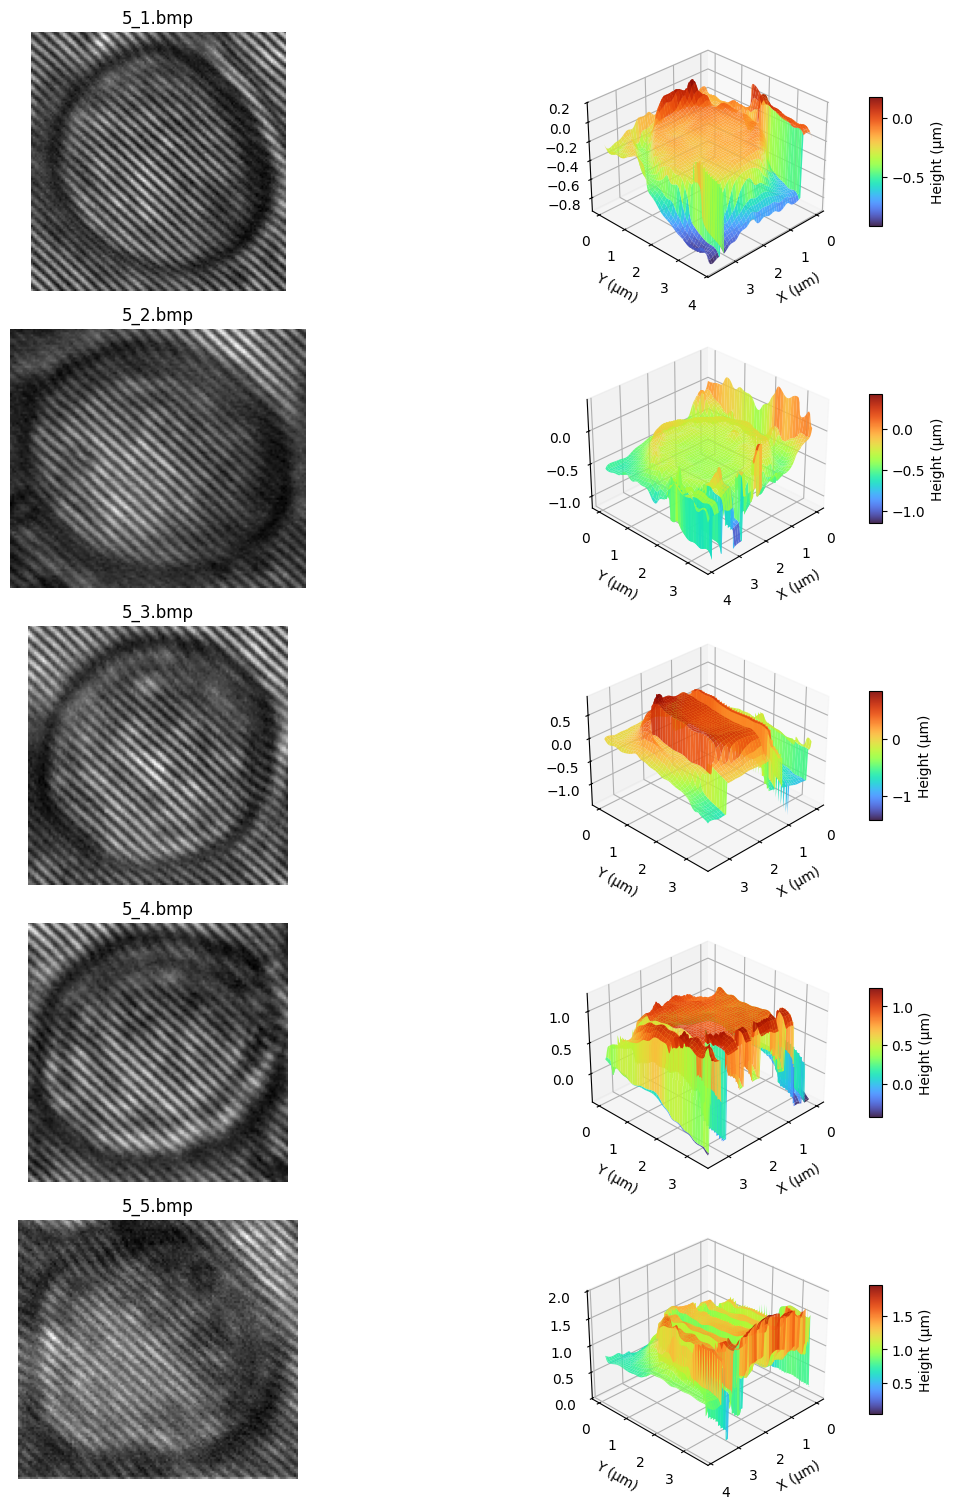

In [41]:
import os
import cv2
import matplotlib.pyplot as plt

files = os.listdir("/content/single_erythrocytes_5")
files.sort()


n_show = 5
files = files[:n_show]

fig = plt.figure(figsize=(12, 3*n_show))

for idx, filename in enumerate(files):
    image = cv2.imread("/content/single_erythrocytes_5/" + filename, cv2.IMREAD_GRAYSCALE)

    ax1 = plt.subplot(n_show, 2, idx*2 + 1)
    ax1.imshow(image, cmap='gray')
    ax1.set_title(filename)
    ax1.axis('off')

    ax2 = plt.subplot(n_show, 2, idx*2 + 2, projection='3d')


    plot_3d_erythrocyte(image)

plt.tight_layout()
plt.show()

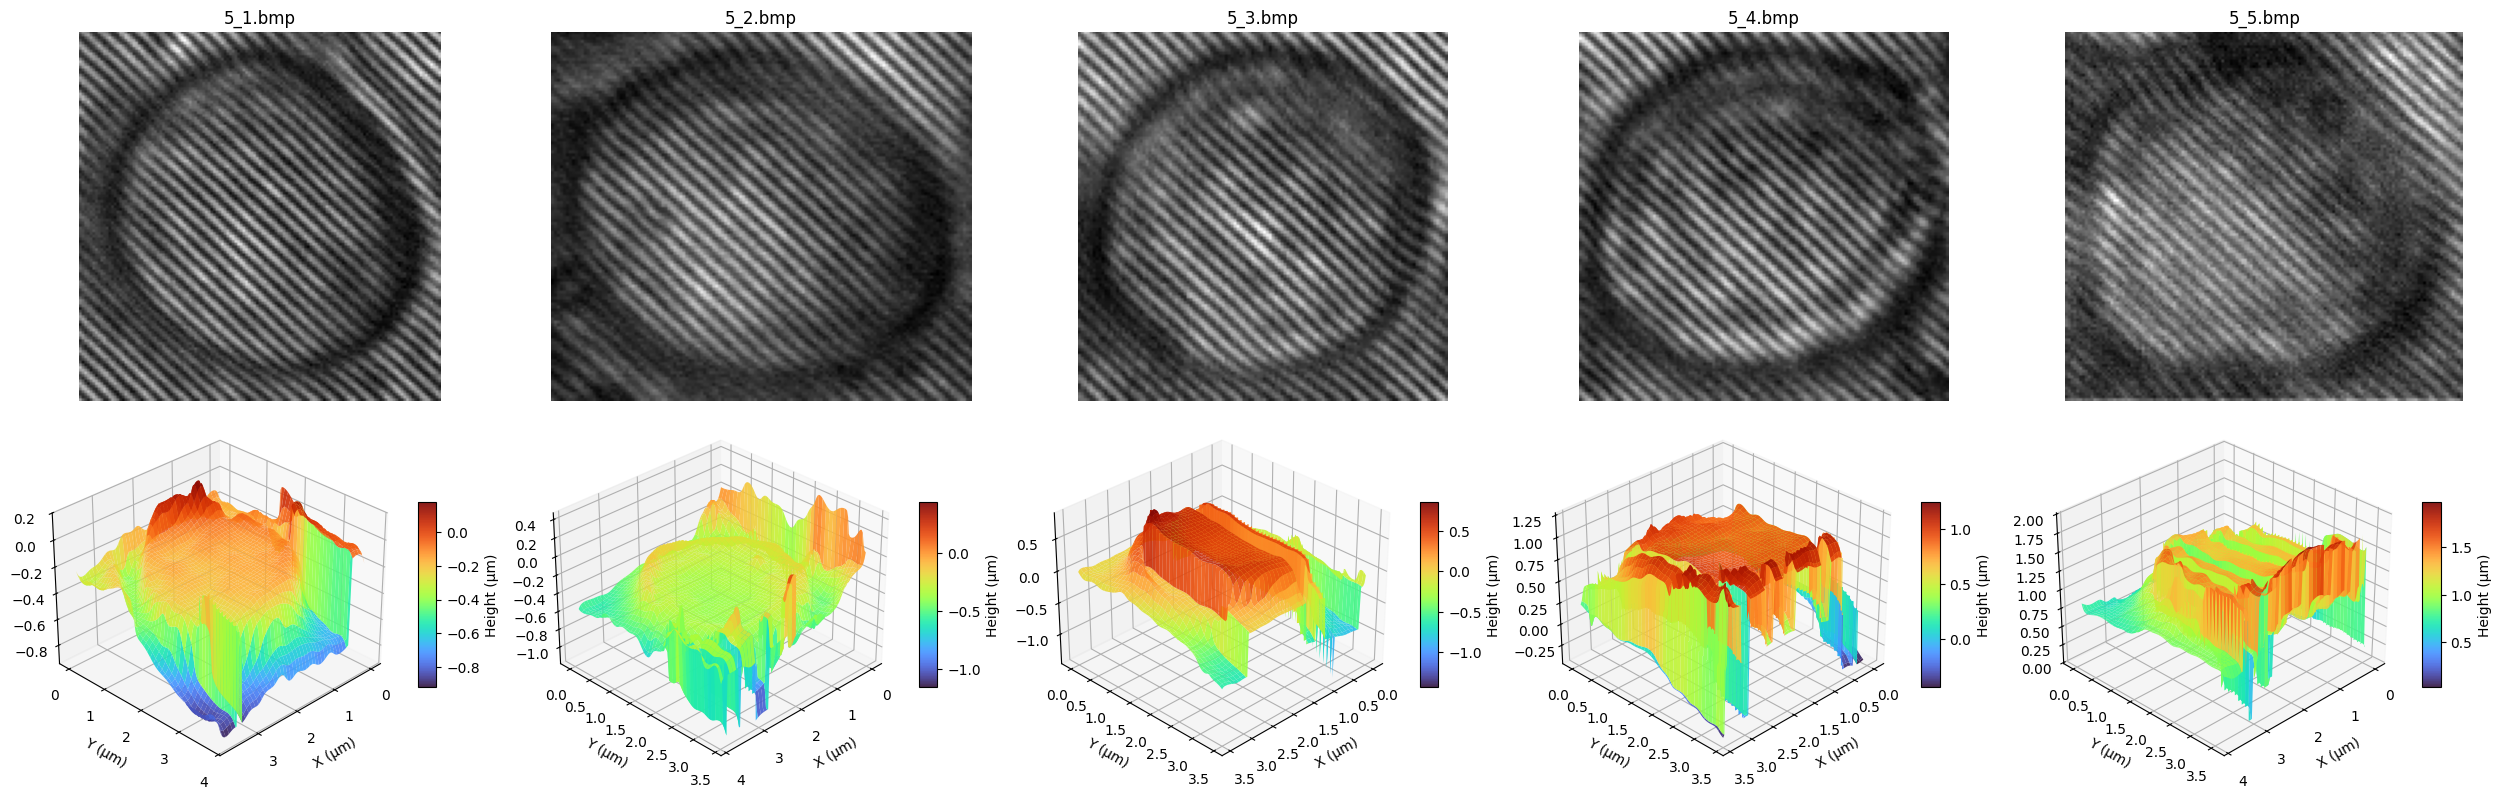

In [42]:
import os
import cv2
import matplotlib.pyplot as plt

files = os.listdir("/content/single_erythrocytes_5")
files.sort()

n_show = 5
files = files[:n_show]

fig = plt.figure(figsize=(5*n_show, 8))

for idx, filename in enumerate(files):
    image = cv2.imread("/content/single_erythrocytes_5/" + filename, cv2.IMREAD_GRAYSCALE)


    ax1 = plt.subplot(2, n_show, idx + 1)
    ax1.imshow(image, cmap='gray')
    ax1.set_title(filename)
    ax1.axis('off')

    ax2 = plt.subplot(2, n_show, n_show + idx + 1, projection='3d')
    plot_3d_erythrocyte(image)

plt.tight_layout()
plt.show()

## Enhancing interference fringes contrast

In [68]:
def enhance_fringes_contrast(img, boost_factor=2.0, mask_radius=20, filter_radius=15):
    fft = np.fft.fftshift(np.fft.fft2(img))
    h, w = img.shape
    cy, cx = h//2, w//2

    Y, X = np.ogrid[:h, :w]
    center_mask = (X-cx)**2 + (Y-cy)**2 <= mask_radius**2
    spectrum = np.abs(fft)
    spectrum_masked = spectrum.copy()
    spectrum_masked[center_mask] = 0

    max_y, max_x = np.unravel_index(np.argmax(spectrum_masked), spectrum_masked.shape)

    pos_mask = (Y - max_y)**2 + (X - max_x)**2 < filter_radius**2
    fft[pos_mask] *= boost_factor

    enhanced_img = np.abs(np.fft.ifft2(np.fft.ifftshift(fft)))

    return enhanced_img

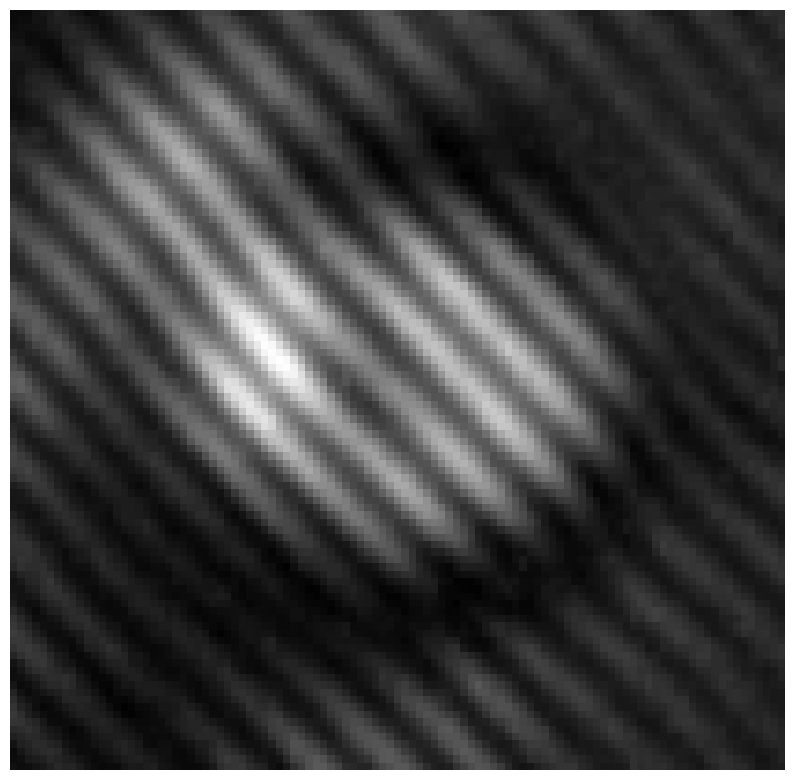

In [75]:
img16 = cv2.imread("Img16_1.bmp", cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(10, 10))
plt.imshow(img16, cmap='gray')
plt.axis('off')
plt.show()

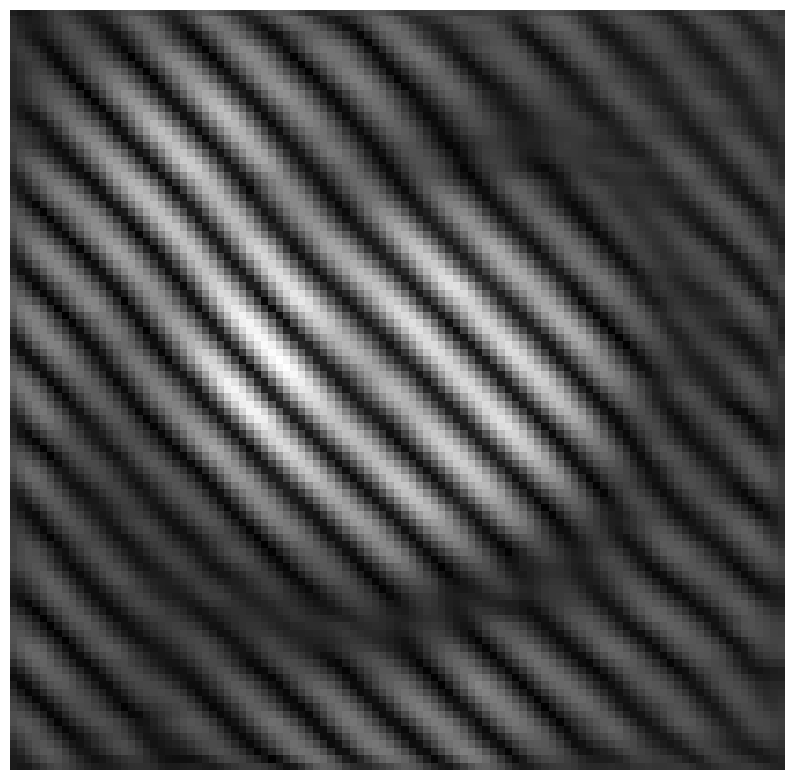

In [74]:
enahnced_img16 = enhance_fringes_contrast(img16, boost_factor = 10)
plt.figure(figsize=(10, 10))
plt.imshow(enahnced_img16, cmap='gray')
plt.axis('off')
plt.show()

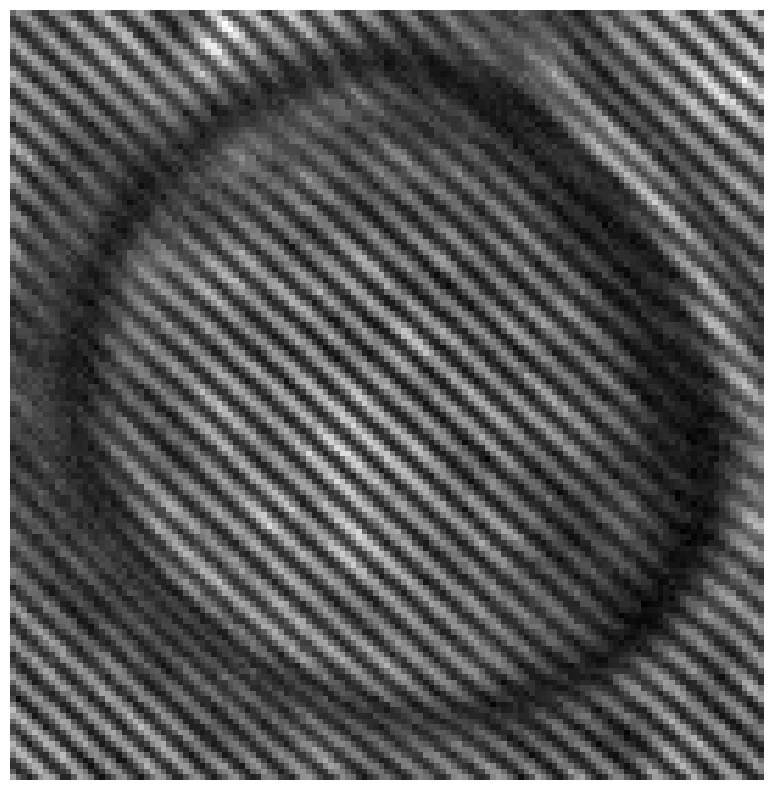

In [59]:
img = cv2.imread("/content/single_erythrocytes_5/5_1.bmp", cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(10, 10))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

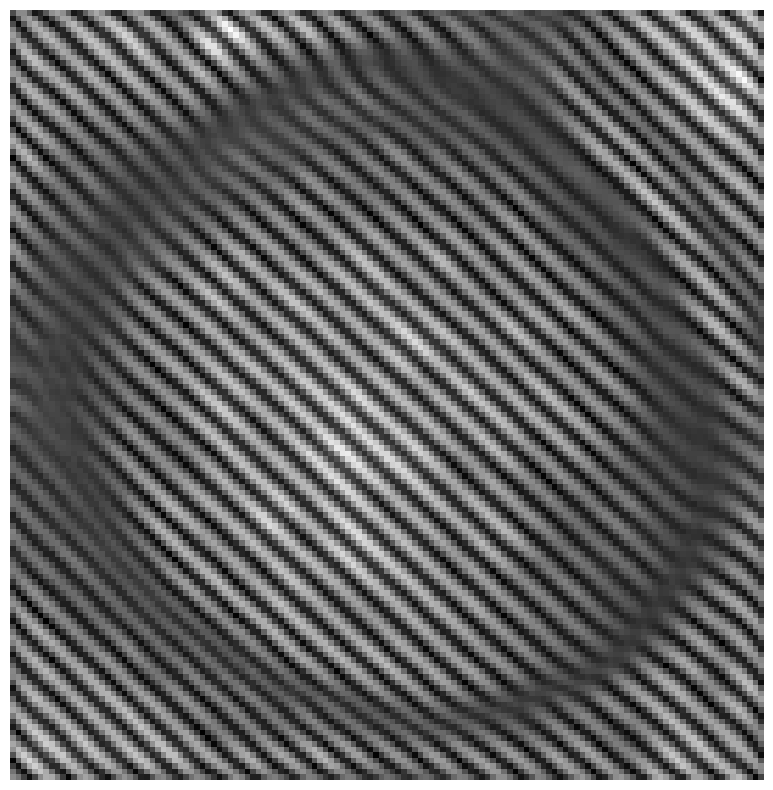

In [76]:
plt.figure(figsize=(10, 10))
plt.imshow(enhance_fringes_contrast(img, boost_factor=10), cmap='gray')
plt.axis('off')
plt.show()